<a href="https://colab.research.google.com/github/aks2093/covariate-shift-in-image-similarity-tasks/blob/main/emnist_dataset_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np

data_path = "/content/drive/My Drive/emnist"

**Read Data**

In [2]:
train_data_path = os.path.join(data_path, "emnist-letters-train.csv")
test_data_path = os.path.join(data_path, "emnist-letters-test.csv")

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
print("train_data shape: {}".format(train_data.shape))
print("test_data shape: {}".format(test_data.shape))

train_data shape: (88799, 785)
test_data shape: (14799, 785)


**Visualize few rows of train data**

In [3]:
train_data.head(5)

,23,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,...,0.376,0.377,0.378,0.379,0.380,0.381,0.382,0.383,0.384,0.385,0.386,0.387,0.388,0.389,0.390,0.391,0.392,0.393,0.394,0.395,0.396,0.397,0.398,0.399,0.400,0.401,0.402,0.403,0.404,0.405,0.406,0.407,0.408,0.409,0.410,0.411,0.412,0.413,0.414,0.415
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Defining Required x_columns and rotate function to visualize the images**

In [4]:
x_columns = train_data.columns.to_list()
x_columns.remove("23")
y_column = ["23"]

def rotate(image):
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

**Getting visualization of few images**

In [5]:
from google.colab.patches import cv2_imshow

x_data = train_data[x_columns]
num_images = 10
demo_image = x_data.iloc[0:num_images,:].values

for i in range(num_images):
    image = demo_image[i].reshape((28,28))
    image = rotate(image)
    print(i, demo_image.shape)
    cv2_imshow(image)

0 (10, 784)


1 (10, 784)


2 (10, 784)


3 (10, 784)


4 (10, 784)


5 (10, 784)


6 (10, 784)


7 (10, 784)


8 (10, 784)


9 (10, 784)


**Lets check the number of data points in each class**

There are 26 different classes:
[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]

In [6]:
train_data.groupby("23")["23"].count()

23
1     3396
2     3396
3     3419
4     3398
5     3437
6     3394
7     3385
8     3424
9     3428
10    3402
11    3438
12    3415
13    3402
14    3365
15    3408
16    3430
17    3435
18    3419
19    3392
20    3436
21    3419
22    3422
23    3422
24    3437
25    3453
26    3427
Name: 23, dtype: int64

**Visualizing the few images in class "1"**

In [8]:
A = train_data[train_data["23"]==1]

from google.colab.patches import cv2_imshow
a_data = A[x_columns]
num_images = 20
demo_image = a_data.iloc[0:num_images,:].values
for i in range(num_images):
    image = demo_image[i].reshape((28,28))
    image = rotate(image)
    print(i, demo_image.shape)
    cv2_imshow(image)

0 (20, 784)


1 (20, 784)


2 (20, 784)


3 (20, 784)


4 (20, 784)


5 (20, 784)


6 (20, 784)


7 (20, 784)


8 (20, 784)


9 (20, 784)


10 (20, 784)


11 (20, 784)


12 (20, 784)


13 (20, 784)


14 (20, 784)


15 (20, 784)


16 (20, 784)


17 (20, 784)


18 (20, 784)


19 (20, 784)


**According to the problem statement we need to ommit any 6 classes randomly and do training on rest 20 classes.**

So lets make list of them.

**Excluded classes** = [2, 15, 20, 6, 14, 25]

**kept classes** = [1,3,4,5,7,8,9,10,11,12,13,16,17,18,19,21,22,23,24,26]

In [9]:
excluded_classes = [2, 15, 20, 6, 14, 25]
kept_classes = [1,3,4,5,7,8,9,10,11,12,13,16,17,18,19,21,22,23,24,26]

new_train_data = train_data[train_data["23"]!=2]
new_train_data = new_train_data[new_train_data["23"]!=15]
new_train_data = new_train_data[new_train_data["23"]!=20]
new_train_data = new_train_data[new_train_data["23"]!=6]
new_train_data = new_train_data[new_train_data["23"]!=14]
new_train_data = new_train_data[new_train_data["23"]!=25]

print(new_train_data.values.shape)

(68347, 785)


Now we need to create similar image pairs and dissimilar image pairs.

To achieve this we make below Naive assumption:

if images are in the same group or belong to same class then similarity is 1 otherwise it is 0.

If we randomly selected all of the images we would likely end up with most images in different groups.

**Logic of generating similar image pair:** In the pair first we will pick an image of any class then another image will be picked up by random sampling in the same class and label=1 will be given to that pair.

**Logic of generating dissimilar image pair:** In the pair first we will pick an image of any class then another image will be picked up by random sampling from the other classes not from the same class and label=0 will be given to that pair.

so if images are similar in the pair then label=1

and if images are dissimilar in the pair then label=0


**Below function is defined to genrate image pairs and labels associated with them.**


In [11]:
def create_image_pairs(dataframe, classes, create_similar_pair=True, data_type="train", label=1):
    labels = []
    pairs = []
    triplets = []
    for cls in classes:
        class_df = dataframe[dataframe["23"]==cls]

        if not create_similar_pair:
            rest_other_classes_data = dataframe[dataframe["23"]!=cls]

        for idx, row in class_df.iterrows():
            data1 = row[x_columns].values
            data1 = data1.reshape((28,28))
            image_data1 = rotate(data1)

            if create_similar_pair:
                sampled_row = class_df.sample()
            else:
                sampled_row = rest_other_classes_data.sample()

            data2 = sampled_row[x_columns].values
            data2 = data2.reshape((28,28))
            image_data2 = rotate(data2)

            labels += [label]
            pairs += [[image_data1, image_data2]]
            triplets += [[image_data1, image_data2, [label]]]
        
        print("class: {} Done.".format(cls))

    if create_similar_pair:
        outfile_images = data_type+"_similar_images.npy"
        outfile_labels = data_type+"_similar_images_label.npy"
    else:
        outfile_images = data_type+"_dissimilar_images.npy"
        outfile_labels = data_type+"_dissimilar_images_label.npy"

    np.save(os.path.join(data_path, outfile_images),np.array(pairs))
    np.save(os.path.join(data_path, outfile_labels),np.array(labels))

    return np.array(pairs), np.array(labels)


**Creating pair of similar Images pairs and their labels for training**

In [12]:
similar_images_pairs, similar_images_labels = create_image_pairs(new_train_data, kept_classes, create_similar_pair=True, data_type="train", label=1)
print("similar_images_pairs shape: {}".format(similar_images_pairs.shape))
print("similar_images_labels shape: {}".format(similar_images_labels.shape))
print("train_data shape: {}".format(new_train_data.shape))

class: 1 Done.
class: 3 Done.
class: 4 Done.
class: 5 Done.
class: 7 Done.
class: 8 Done.
class: 9 Done.
class: 10 Done.
class: 11 Done.
class: 12 Done.
class: 13 Done.
class: 16 Done.
class: 17 Done.
class: 18 Done.
class: 19 Done.
class: 21 Done.
class: 22 Done.
class: 23 Done.
class: 24 Done.
class: 26 Done.
similar_images_pairs shape: (68347, 2, 28, 28)
similar_images_labels shape: (68347,)
train_data shape: (68347, 785)


**Visualizing few similar image pairs**

In [13]:
cv2_imshow(similar_images_pairs[:,0][1])
cv2_imshow(similar_images_pairs[:,1][1])
cv2_imshow(similar_images_pairs[:,0][2])
cv2_imshow(similar_images_pairs[:,1][2])
cv2_imshow(similar_images_pairs[:,0][3])
cv2_imshow(similar_images_pairs[:,1][3])
cv2_imshow(similar_images_pairs[:,0][4])
cv2_imshow(similar_images_pairs[:,1][4])

**Create Dissimilar images pairs and their labels for training**

In [14]:
dissimilar_images_pairs, dissimilar_images_labels = create_image_pairs(new_train_data, kept_classes, create_similar_pair=False, data_type="train", label=0)
print("dissimilar_images_pairs shape: {}".format(dissimilar_images_pairs.shape))
print("dissimilar_images_labels shape: {}".format(dissimilar_images_labels.shape))
print("train_data shape: {}".format(new_train_data.shape))

class: 1 Done.
class: 3 Done.
class: 4 Done.
class: 5 Done.
class: 7 Done.
class: 8 Done.
class: 9 Done.
class: 10 Done.
class: 11 Done.
class: 12 Done.
class: 13 Done.
class: 16 Done.
class: 17 Done.
class: 18 Done.
class: 19 Done.
class: 21 Done.
class: 22 Done.
class: 23 Done.
class: 24 Done.
class: 26 Done.
dissimilar_images_pairs shape: (68347, 2, 28, 28)
dissimilar_images_labels shape: (68347,)
train_data shape: (68347, 785)


In [15]:
dissimilar_images_labels[:4]

array([0, 0, 0, 0])

**Visualize dissimilar image pairs**

In [16]:
cv2_imshow(dissimilar_images_pairs[:,0][1])
cv2_imshow(dissimilar_images_pairs[:,1][1])
cv2_imshow(dissimilar_images_pairs[:,0][2])
cv2_imshow(dissimilar_images_pairs[:,1][2])
cv2_imshow(dissimilar_images_pairs[:,0][3])
cv2_imshow(dissimilar_images_pairs[:,1][3])
cv2_imshow(dissimilar_images_pairs[:,0][4])
cv2_imshow(dissimilar_images_pairs[:,1][4])

**Preparing test data in the same way the traing data was prepared**

But here we will generate the images pairs from the classes which we excluded in while preparing the training data.
i.e Excluded classes = [2, 15, 20, 6, 14, 25]

so this test data would be totally unseen to the model.


In [17]:
test_data = train_data[train_data["23"].isin(excluded_classes)]
print(test_data.shape)
test_similar_images_pairs, test_similar_images_labels = create_image_pairs(train_data, excluded_classes, create_similar_pair=True, data_type="test", label=1)
print("test_similar_images_pairs shape: {}, test_similar_images_labels shape: {}".format(test_similar_images_pairs.shape, test_similar_images_labels.shape))
test_dissimilar_images_pairs, test_dissimilar_images_labels = create_image_pairs(train_data, excluded_classes, create_similar_pair=False, data_type="test", label=0)
print("test_dissimilar_images_pairs shape: {}, test_dissimilar_images_labels shape: {}".format(test_dissimilar_images_pairs.shape, test_dissimilar_images_labels.shape))

(20452, 785)
class: 2 Done.
class: 15 Done.
class: 20 Done.
class: 6 Done.
class: 14 Done.
class: 25 Done.
test_similar_images_pairs shape: (20452, 2, 28, 28), test_similar_images_labels shape: (20452,)
class: 2 Done.
class: 15 Done.
class: 20 Done.
class: 6 Done.
class: 14 Done.
class: 25 Done.
test_dissimilar_images_pairs shape: (20452, 2, 28, 28), test_dissimilar_images_labels shape: (20452,)


Read the saved data

In [3]:
import numpy as np

similar_images_pairs = np.load(os.path.join(data_path,"train_similar_images.npy"))
similar_images_labels = np.load(os.path.join(data_path,"train_similar_images_label.npy"))
dissimilar_images_pairs = np.load(os.path.join(data_path,"train_dissimilar_images.npy"))
dissimilar_images_labels = np.load(os.path.join(data_path,"train_dissimilar_images_label.npy"))
test_similar_images_pairs = np.load(os.path.join(data_path,"test_similar_images.npy"))
test_similar_images_labels = np.load(os.path.join(data_path,"test_similar_images_label.npy"))
test_dissimilar_images_pairs = np.load(os.path.join(data_path,"test_dissimilar_images.npy"))
test_dissimilar_images_labels = np.load(os.path.join(data_path,"test_dissimilar_images_label.npy"))

print("similar_images_pairs shape: {}".format(similar_images_pairs.shape))
print("similar_images_labels shape: {}".format(similar_images_labels.shape))
print("dissimilar_images_pairs shape: {}".format(dissimilar_images_pairs.shape))
print("dissimilar_images_labels shape: {}".format(dissimilar_images_labels.shape))
print("test_similar_images_pairs shape: {}".format(test_similar_images_pairs.shape))
print("test_similar_images_labels shape: {}".format(test_similar_images_labels.shape))
print("test_dissimilar_images_pairs shape: {}".format(test_dissimilar_images_pairs.shape))
print("test_dissimilar_images_labels shape: {}".format(test_dissimilar_images_labels.shape))

similar_images_pairs shape: (68347, 2, 28, 28)
similar_images_labels shape: (68347,)
dissimilar_images_pairs shape: (68347, 2, 28, 28)
dissimilar_images_labels shape: (68347,)
test_similar_images_pairs shape: (20452, 2, 28, 28)
test_similar_images_labels shape: (20452,)
test_dissimilar_images_pairs shape: (20452, 2, 28, 28)
test_dissimilar_images_labels shape: (20452,)


**Shuffling Train and Test data**

In [4]:
import random

print("Before Shuffling: ")
total_train_image_pairs = np.concatenate((similar_images_pairs, dissimilar_images_pairs))
total_train_labels = np.concatenate((similar_images_labels, dissimilar_images_labels))
print("total_train_image_pairs shape: {}, total_train_labels shape: {}".format(total_train_image_pairs.shape, total_train_labels.shape))
total_test_image_pairs = np.concatenate((test_similar_images_pairs, test_dissimilar_images_pairs))
total_test_labels = np.concatenate((test_similar_images_labels, test_dissimilar_images_labels))
print("total_test_image_pairs shape: {}, total_test_labels: {}".format(total_test_image_pairs.shape, total_test_labels.shape))

print("\n")
print("After Shuffling: ")
c = list(zip(total_train_image_pairs, total_train_labels))
random.shuffle(c)
total_train_image_pairs, total_train_labels = zip(*c)
total_train_image_pairs = np.array(total_train_image_pairs)
total_train_labels = np.array(total_train_labels)
print("total_train_image_pairs shape: {}, total_train_labels shape: {}".format(total_train_image_pairs.shape, total_train_labels.shape))


c = list(zip(total_test_image_pairs, total_test_labels))
random.shuffle(c)
total_test_image_pairs, total_test_labels = zip(*c)
total_test_image_pairs = np.array(total_test_image_pairs)
total_test_labels = np.array(total_test_labels)
print("total_test_image_pairs shape: {}, total_test_labels: {}".format(total_test_image_pairs.shape, total_test_labels.shape))

Before Shuffling: 
total_train_image_pairs shape: (136694, 2, 28, 28), total_train_labels shape: (136694,)
total_test_image_pairs shape: (40904, 2, 28, 28), total_test_labels: (40904,)


After Shuffling: 
total_train_image_pairs shape: (136694, 2, 28, 28), total_train_labels shape: (136694,)
total_test_image_pairs shape: (40904, 2, 28, 28), total_test_labels: (40904,)


**Define Some metric and distance functions**

In [5]:
def euclidean_distance(vect1, vect2):
    x, y = vect1, vect2
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() > 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.cast(y_pred > 0.5, y_true.dtype)))

**Creating a model:**

here we will create a siamese network with below architecture:

**Note**: In the model we are keeping the validation data ratio as 10% to validate the model

Since we are using totally unseen data for testing so test data might have a different distribution from train data. It a problem of **Covariate Shift** so in case of covariate shift, adding  **BatchNormalization** might be useful while traing the model.

**Model output**: model will output the similarity score between images in the pairs. We can choose a optimal threshold on this score to classify them as similar(1) or not similar(0)

**Plese follow below architecture:**

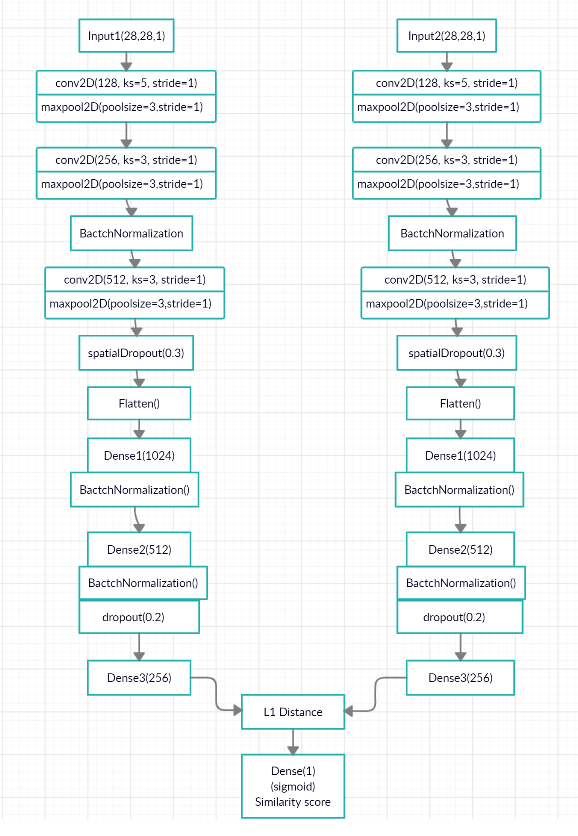



Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 256)          104903424   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256)          0           sequential[0][0]      

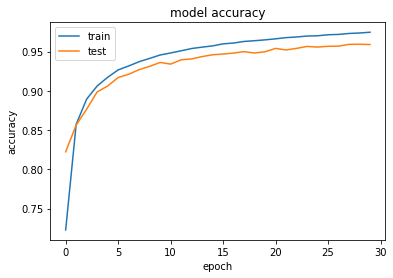

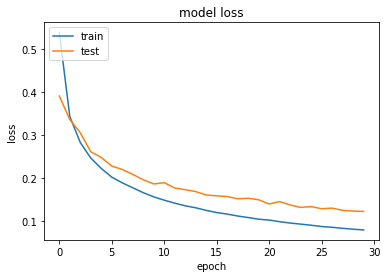

In [6]:
import keras
from keras.layers import Conv2D, Dropout, Flatten, Dense, MaxPooling2D, SpatialDropout2D, Lambda, Input, BatchNormalization
from keras.models import Model
from keras.utils.vis_utils import plot_model
import numpy as np
import pandas as pd
from keras import backend as K
import random
import os
import cv2
from keras.optimizers import SGD, Adam
from sklearn.utils import shuffle

num_classes = 2
epochs = 30

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=50,
    decay_rate=0.0001)

adam = Adam(learning_rate=lr_schedule)
sgd1 = SGD(learning_rate=lr_schedule)
sgd2 = SGD(learning_rate=0.001)


input_shape=(28, 28, 1)

left_input = Input(shape=input_shape)
right_input = Input(shape=input_shape)

base_model  = keras.Sequential()

base_model.add(Conv2D(128, kernel_size=5, input_shape=input_shape, strides=1, activation="relu"))
base_model.add(MaxPooling2D(pool_size=3, strides=1))
# base_model.add(SpatialDropout2D(rate=0.2))

base_model.add(Conv2D(256, kernel_size=3, strides=1, activation="relu"))
base_model.add(MaxPooling2D(pool_size=3, strides=1))
base_model.add(BatchNormalization())

base_model.add(Conv2D(512, kernel_size=3, strides=1, activation="relu"))
base_model.add(MaxPooling2D(pool_size=3, strides=1))
base_model.add(SpatialDropout2D(rate=0.3))



base_model.add(Flatten())
base_model.add(Dense(1024, activation='relu'))
base_model.add(BatchNormalization())
base_model.add(Dense(512, activation='relu'))
base_model.add(BatchNormalization())
base_model.add(Dropout(rate=0.2))
base_model.add(Dense(256, activation="relu"))

encoded_l = base_model(left_input)
encoded_r = base_model(right_input)

L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
# L2_distance = euclidean_distance(encoded_l, encoded_r)

prediction = Dense(1,activation='sigmoid')(L1_distance)
# prediction = Dense(1,activation='sigmoid')(L2_distance)
model = Model(inputs=[left_input,right_input],outputs=prediction)

plot_model(model, to_file='model.png')

early_stopping_callback=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model.compile(loss="binary_crossentropy", optimizer=sgd2, metrics=[accuracy])
print(model.summary())

model_history = model.fit([total_train_image_pairs [:, 0].reshape(-1, 28,28, 1), total_train_image_pairs [:, 1].reshape(-1, 28, 28, 1)], total_train_labels ,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback])

# model.save(os.path.join(path,'letters_similarity_model_sigmoid.h5'))

import matplotlib.pyplot as plt
# summarize history for accracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(data_path,"accuracy_sigmoid.png"))
plt.close()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig(os.path.join(data_path,"loss_sigmoid.png"))
plt.close()

#validation_data=([total_test_image_pairs [:, 0].reshape(-1, 28,28, 1), total_test_image_pairs [:, 1].reshape(-1, 28, 28, 1)], total_test_labels),

**Make Prediction on test data(unseen data)**

Note: 
classes in test data = [2, 15, 20, 6, 14, 25]

classes in train data = [1,3,4,5,7,8,9,10,11,12,13,16,17,18,19,21,22,23,24,26]

In [14]:
predictions = model.predict([total_test_image_pairs [:, 0].reshape(-1, 28,28, 1), total_test_image_pairs [:, 1].reshape(-1, 28, 28, 1)])
print("predictions shape: {}".format(predictions.shape))
print("Accuracy on test data is(with threshold=0.5): {}".format(compute_accuracy(total_test_labels, predictions)*100))

predictions shape: (40904, 1)
Accuracy on test data is(with threshold=0.5): 72.03451985135928


**Conclusion**

1. As we can see from above that out model is able to acheive train_accuracy: 97.46%  and val_accuracy: 95.90 in 30 epochs

2. We are able to achieve 72% Accuracy on test data that includes totally unseen classes to models

3. we can futher improve the results by hyperparameter tuning, by trying different network architectures , by chossing optimal the threshold(in our case it is 0.5)

4. we can perform various experiments to get better results.